In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization





In [4]:
data = pd.read_excel("1390_train_data.xlsx")
df = pd.DataFrame(data)
data.head()

,Additive concentration,MAI,FAI,CsI,CsBr,MABr,MACl,PbI2,PbBr2,PbCl2,...,DMF,DMSO,GBL,Polarity index,Annealing,Etl,Htl,Back contact,Interlayer,PCE (%)
0,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,5.200
1,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.828
2,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.836
3,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,5.070
4,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.980


In [5]:
print(df.isnull().sum())

Additive concentration    0
MAI                       0
FAI                       0
CsI                       0
CsBr                      0
MABr                      0
MACl                      0
PbI2                      0
PbBr2                     0
PbCl2                     0
SnI2                      0
SnCl2                     0
SnBr2                     0
Pb(SCN)2                  0
SnF2                      0
DMF                       0
DMSO                      0
GBL                       0
Polarity index            0
Annealing                 0
Etl                       0
Htl                       0
Back contact              0
Interlayer                0
PCE (%)                   0
dtype: int64


In [6]:
X = df.drop(['PCE (%)'], axis= 1)
y = df['PCE (%)']
print(X.shape, y.shape)

(1390, 24) (1390,)


In [7]:
data = df

print(data.shape)

(1390, 25)


In [8]:
data = df.values.astype(np.float32)


In [ ]:
# import random
# import os

# seed = 42  

# os.environ['PYTHONHASHSEED'] = str(seed)
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)


In [10]:

class VAEConfig:
    input_dim = 25
    latent_dim = 50  
    hidden_dims = [512, 256,128, 64, 32]  
    dropout_rate = 0.2  
    batch_size = 32  
    epochs = 500  
    lr = 0.0001  
    beta = 1  


class AdvancedSampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon



def build_encoder(config):
    inputs = layers.Input(shape=(config.input_dim,))
    x = inputs

    for dim in config.hidden_dims:
        x = layers.Dense(dim, activation='swish')(x)
        x = BatchNormalization()(x)
        x = Dropout(config.dropout_rate)(x)

    z_mean = layers.Dense(config.latent_dim)(x)
    z_log_var = layers.Dense(config.latent_dim)(x)
    z = AdvancedSampling()([z_mean, z_log_var])

    return models.Model(inputs, [z_mean, z_log_var, z], name='encoder')



def build_decoder(config):
    latent_inputs = layers.Input(shape=(config.latent_dim,))
    x = latent_inputs

    for dim in reversed(config.hidden_dims):
        x = layers.Dense(dim, activation='swish')(x)
        x = BatchNormalization()(x)
        x = Dropout(config.dropout_rate)(x)

    outputs = layers.Dense(config.input_dim, activation='linear')(x)  
    return models.Model(latent_inputs, outputs, name='decoder')


class VAEModel(models.Model):
    def __init__(self, encoder, decoder, config, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.config = config
        self.beta = config.beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.int32)  

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=1)) / self.config.input_dim

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )


            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.current_epoch.assign_add(1)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        x = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=1)) / self.config.input_dim

        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        

        total_loss = reconstruction_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }



config = VAEConfig()
encoder = build_encoder(config)
decoder = build_decoder(config)
vae = VAEModel(encoder, decoder, config)
vae.compile(optimizer=tf.keras.optimizers.Adam(config.lr, clipvalue=1.0)) 



vae.fit(data, epochs=config.epochs, batch_size=config.batch_size, validation_split=0.2)




Epoch 1/500
35/35 [==============================] - 1s 8ms/step - loss: 9.6987 - reconstruction_loss: 9.4082 - kl_loss: 0.1151 - beta: 1.0000 - val_loss: 7.8013 - val_reconstruction_loss: 6.9549 - val_kl_loss: 0.8465 - val_beta: 1.0000
Epoch 2/500
35/35 [==============================] - 0s 3ms/step - loss: 5.3102 - reconstruction_loss: 2.6356 - kl_loss: 1.2758 - beta: 1.0000 - val_loss: 2.1245 - val_reconstruction_loss: 1.4246 - val_kl_loss: 0.7000 - val_beta: 1.0000
Epoch 3/500
35/35 [==============================] - 0s 3ms/step - loss: 2.1542 - reconstruction_loss: 1.5766 - kl_loss: 0.4780 - beta: 1.0000 - val_loss: 1.7339 - val_reconstruction_loss: 1.2342 - val_kl_loss: 0.4997 - val_beta: 1.0000
Epoch 4/500
35/35 [==============================] - 0s 3ms/step - loss: 1.8377 - reconstruction_loss: 1.3711 - kl_loss: 0.3892 - beta: 1.0000 - val_loss: 1.5440 - val_reconstruction_loss: 1.0962 - val_kl_loss: 0.4478 - val_beta: 1.0000
Epoch 5/500
35/35 [==============================] -

In [11]:
def generate_samples(model, num_samples=1000):
    z_samples = np.random.normal(size=(num_samples, config.latent_dim))
    return model.decoder.predict(z_samples)

In [12]:
generated_samples = generate_samples(vae, num_samples=1000)

print("generated samples:")
print(generated_samples)


print(f"mean: {np.mean(generated_samples, axis=0)}")

print(f"Standard deviation: {np.std(generated_samples, axis=0)}")

32/32 [==============================] - 0s 694us/step
generated samples:
[[-4.72012907e-02  5.35414398e-01  5.43611288e-01 ...  4.48300809e-01
  -9.42071602e-02  1.45534716e+01]
 [ 4.32862568e+00  1.34668469e-01  6.20845020e-01 ...  1.10767591e+00
   1.36343312e+00  1.05156012e+01]
 [ 1.79016757e+00  1.42618418e-01  5.16388893e-01 ...  1.24952102e+00
   1.64322829e+00  7.66509533e+00]
 ...
 [ 2.40979701e-01  1.77116573e-01  3.40502232e-01 ...  2.33588958e+00
  -1.13212705e-01  1.04323864e+01]
 [-1.89643711e-01  9.40676928e-01  1.32498726e-01 ...  3.88294980e-02
  -1.59598172e-01  1.16498413e+01]
 [-6.67866990e-02  5.01750410e-01  6.59364641e-01 ...  2.92445272e-01
  -1.16137741e-03  1.66613331e+01]]
mean: [ 1.27113569e+00  4.53268379e-01  4.58982766e-01  6.64369613e-02
  7.06663355e-03  4.91433255e-02 -1.39073115e-02  6.30600035e-01
  6.86629787e-02  1.56803075e-02  3.50449175e-01  5.79313841e-03
 -1.02387159e-03  8.72072112e-03  2.91511193e-02  5.60182691e-01
  3.55410159e-01  7.0963

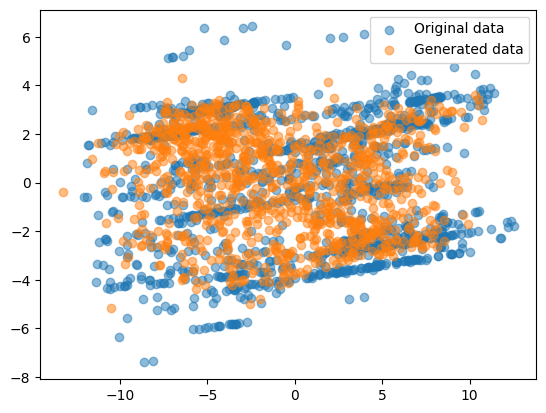

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
original_2d = pca.fit_transform(data)
generated_2d = pca.transform(generated_samples)

plt.scatter(original_2d[:, 0], original_2d[:, 1], label="Original data", alpha=0.5)
plt.scatter(generated_2d[:, 0], generated_2d[:, 1], label="Generated data", alpha=0.5)
plt.legend()
plt.show()